## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:



# Project Title

## Overview

## Business Problem

## Data Understanding

We need to find outcomes to solve our business problem:
- tn.movie_budgets.csv.gz contains `production_budget`, `domestic_gross`, `worldwide_gross`
- im.db has `movie_ratings` table with `averagerating` and `numvotes`

We also need features that might relate to our outcomes:
- im.db has movie names, genres, and names of actors and directors
- bom.movie_gross.csv.gz contains the studio that produced each movie

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# print big numbers in pd.DataFrame (instead of scientific notation)
pd.set_option('display.precision', 12)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## The Numbers Data
- Contains `production_budget`, `domestic_gross`, `worldwide_gross` formatted as string with special characters (e.g., $425,000,000)

In [2]:
# create The Numbers data frame
tn_movie_budgets_df = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
# show it contains movies, both big and small
tn_movie_budgets_df.iloc[[5, 500, 5000]]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
500,1,"Jun 8, 2007",Ocean's Thirteen,"$85,000,000","$117,144,465","$311,744,465"
5000,1,"Dec 1, 2015",Shark Lake,"$2,000,000",$0,$0


### Data Cleaning

In [3]:
#Helper function to clean the money columns
def convert_money_string(money_series):
    '''
    This function takes a pd.Series with string values representing money (USD) and converts that string to float
    '''
    return money_series.str.replace('$','').str.replace(',','').astype(float)

In [4]:
# Here we clean all of the money cells so they can be converted into floats
# and then be turned into a floating point in millions
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    tn_movie_budgets_df[col] = convert_money_string(tn_movie_budgets_df[col])
    col_mil = f"{col}_mil"
    tn_movie_budgets_df[col_mil] = tn_movie_budgets_df[col] / 1000000

### Feature Engineering

In [5]:
# Here we calculated worldwide_profit in millions for each movie
tn_movie_budgets_df['worldwide_profit_mil'] = tn_movie_budgets_df['worldwide_gross_mil'] - tn_movie_budgets_df['production_budget_mil']
# Here we calculated return on investment for each movie
tn_movie_budgets_df['ROI'] = tn_movie_budgets_df['worldwide_profit_mil'] / tn_movie_budgets_df['production_budget_mil']

## Box Office Mojo Data
- Contains `domestic_gross` and `foreign_gross`
- `foreign_gross` is formatted as string with special characters (e.g., 425,000,000)

In [6]:
# Here we read in the Box Office Mojo data frame
bom_df = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
# once again to show variety of movies in the data frame
bom_df.iloc[[3,300,3000]]

,title,studio,domestic_gross,foreign_gross,year
3,Inception,WB,292600000.00,535700000,2010
300,Saint John of Las Vegas,IVP,103000.00,9100,2010
3000,My Life as a Zucchini,GK,310000.00,NaN,2017


### Data Cleaning

In [7]:
for col in ['foreign_gross']:
    bom_df[col] = convert_money_string(bom_df[col])
    col_mil = f"{col}_mil"
    bom_df[col_mil] = bom_df[col] / 1000000

In [8]:
# Here we are infering that missing values actually represent no money made in a given region
bom_df['foreign_gross'].fillna(0, inplace=True)
bom_df['domestic_gross'].fillna(0, inplace=True)
bom_df['foreign_gross_mil'].fillna(0, inplace=True)

### Feature Engineering

In [9]:
bom_df['domestic_gross_mil'] = bom_df['domestic_gross'] / 1000000
bom_df['bom_worldwide_gross_mil'] = bom_df['domestic_gross_mil'] + bom_df['foreign_gross_mil']

### Internet Movie Database (IMDB) SQL database

In [10]:
# Create the connect to im.db database
con = sqlite3.connect('../../im.db')

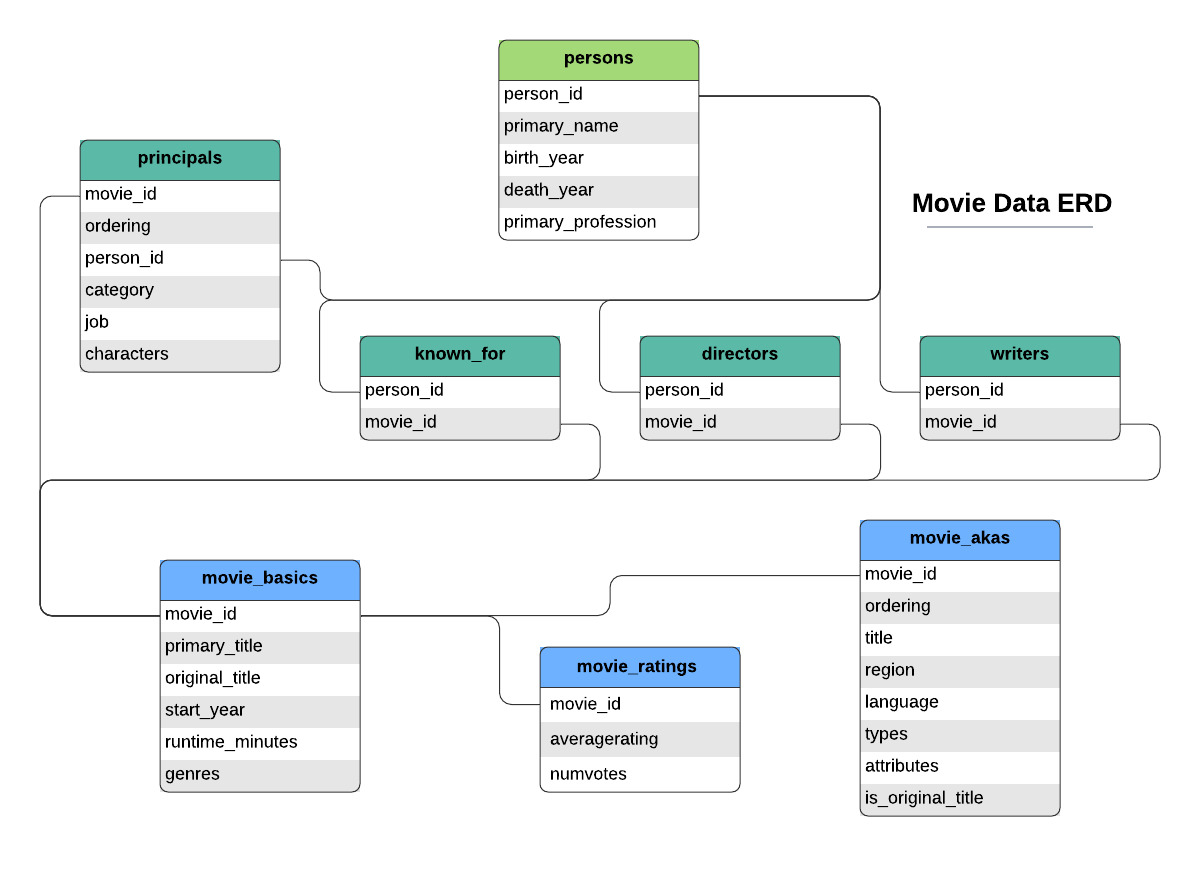



#### Use SQL to get info about `movie_basics` and `movie_ratings`
- `movie_ratings`
    - `averagerating` and `numvotes` are columns of imdb ratings
- `movie_basics` table
    - `genres` is a string that contains multiple genres (separated by commas)
    - `primary_title` has duplicate rows with same value

#### movie_ratings table

In [11]:
# What do sample values look like?
# I don't think we need the cell you had below based on the exclusion of that type of info from aab template
pd.read_sql("""
SELECT
    *
FROM
    movie_ratings
LIMIT 5
""", con)

,movie_id,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


#### movie_basics table
This genres column will need to parsed in pandas before it can be utilized.

In [12]:
# What do sample values look like?
pd.read_sql("""
SELECT
    *
FROM
    movie_basics
LIMIT 5
""", con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"


#### Use SQL to get info about   `persons` and `principals`

#### persons table
This has information in the primary_profession column that is useful, but it will be more correct to work with the category column in the principals table below.

In [13]:
# What do sample values look like?
pd.read_sql("""
SELECT
    *
FROM
    persons
LIMIT 5
""", con)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,None,None,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,None,None,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,None,None,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,None,None,"production_designer,art_department,set_decorator"


#### principals table
The category provides the role that a person played in a specific movie.

In [14]:
# What do sample values look like?
pd.read_sql("""
SELECT
    *
FROM
    principals
LIMIT 5
""", con)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


## Data Preparation

#### Let's JOIN im.db `movie_basics`  and `movie_ratings`
- read into `imdb_ratings_df` DataFrame

In [15]:
### Look into who the primary directors are
# Usee LEFT JOIN to keep all movies, even if they are not in the movie_ratings table
imdb_ratings_df = pd.read_sql("""

SELECT
    b.movie_id, b.primary_title, b.original_title, b.start_year, b.runtime_minutes, b.genres,
    r.averagerating, r.numvotes
FROM
    movie_basics as b
    LEFT JOIN movie_ratings as r
        USING(movie_id)

""", con)
imdb_ratings_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama",7.00,77.00
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama",7.20,43.00
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama,6.90,4517.00
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama",6.10,13.00
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy",6.50,119.00
...,...,...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama,nan,nan
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary,nan,nan
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy,nan,nan
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,None,nan,nan


#### Let's get im.db `persons`  and `principals`
- Read into `imdb_principals_df` DataFrame
- I'm keeping info about principals separate, because relationship of `movie_id` to `person_id` is one-to-many and the resulting data frame would be too bulky 
    - (i.e., a `person_id` can have multiple roles in one `movie_id`)
    - There are multiple directors for some movies, and we will need to figure out how to deal with that when determining which directors are best
- Still want to merge `imdb_principals_df` with `imdb_ratings_df` to put movie info with principals

In [16]:
# Used LEFT JOIN to keep all principals, even if they have no persons info
imdb_principals_df = pd.read_sql("""

SELECT
    *
FROM
    principals
    LEFT JOIN persons
        USING(person_id)

""", con)
imdb_principals_df

,movie_id,ordering,person_id,category,job,characters,primary_name,birth_year,death_year,primary_profession
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]",Tommy Dysart,nan,nan,actor
1,tt0111414,2,nm0398271,director,None,None,Frank Howson,1952.00,nan,"actor,writer,producer"
2,tt0111414,3,nm3739909,producer,producer,None,Barry Porter-Robinson,nan,nan,"producer,art_department"
3,tt0323808,10,nm0059247,editor,None,None,Sean Barton,1944.00,nan,"editor,editorial_department,assistant_director"
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]",Brittania Nicol,nan,nan,"actress,soundtrack"
...,...,...,...,...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]",Kenneth Cranham,1944.00,nan,"actor,soundtrack"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]",Pearl Mackie,1987.00,nan,actress
1028183,tt9692684,3,nm10441594,director,None,None,Guy Jones,nan,nan,director
1028184,tt9692684,4,nm6009913,writer,writer,None,Sabrina Mahfouz,nan,nan,writer


In [17]:
# Merge imdb_ratings_df with imdb_principals_df 
# This could be reordered to the bottom of the notebook
# left join in order to keep all principals
imdb_principals_df = imdb_principals_df.merge(imdb_ratings_df, on='movie_id', how='left')
imdb_principals_df

,movie_id,ordering,person_id,category,job,characters,primary_name,birth_year,death_year,primary_profession,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]",Tommy Dysart,nan,nan,actor,A Thin Life,A Thin Life,2018,75.00,Comedy,nan,nan
1,tt0111414,2,nm0398271,director,None,None,Frank Howson,1952.00,nan,"actor,writer,producer",A Thin Life,A Thin Life,2018,75.00,Comedy,nan,nan
2,tt0111414,3,nm3739909,producer,producer,None,Barry Porter-Robinson,nan,nan,"producer,art_department",A Thin Life,A Thin Life,2018,75.00,Comedy,nan,nan
3,tt0323808,10,nm0059247,editor,None,None,Sean Barton,1944.00,nan,"editor,editorial_department,assistant_director",The Wicker Tree,The Wicker Tree,2011,96.00,"Drama,Horror",3.90,2328.00
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]",Brittania Nicol,nan,nan,"actress,soundtrack",The Wicker Tree,The Wicker Tree,2011,96.00,"Drama,Horror",3.90,2328.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]",Kenneth Cranham,1944.00,nan,"actor,soundtrack",Disnatured,Disnatured,2016,nan,"Drama,Fantasy,Horror",nan,nan
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]",Pearl Mackie,1987.00,nan,actress,Disnatured,Disnatured,2016,nan,"Drama,Fantasy,Horror",nan,nan
1028183,tt9692684,3,nm10441594,director,None,None,Guy Jones,nan,nan,director,Disnatured,Disnatured,2016,nan,"Drama,Fantasy,Horror",nan,nan
1028184,tt9692684,4,nm6009913,writer,writer,None,Sabrina Mahfouz,nan,nan,writer,Disnatured,Disnatured,2016,nan,"Drama,Fantasy,Horror",nan,nan


## Filter data to those movies that Microsoft Studios might produce
- Assume that Microsoft wants to compete with more productive movie studios
- Assume that Microsoft is not interested in producing "art house" movies that are not popular or profitable
- Assume that Microsoft wants to produce popular movies (with large following and high ratings)

In [18]:
bom_studio_gross = bom_df.groupby('studio')['bom_worldwide_gross_mil'].sum()


Maybe have a few sentences about how all of the money is made at the top, pointing out the large difference between the median, 75th percentile, and max

In [19]:
# Let's look at studios above 90th percentile in gross sales
gross_sales_90 = np.percentile(bom_studio_gross, 90)
filt = bom_studio_gross > gross_sales_90
competing_studios = bom_studio_gross[filt].index

In [20]:
filt = bom_df['studio'].isin(competing_studios)
bom_competing_studios_df = bom_df[filt]
print(f"Number of movies made by top 10% grossing studios: {bom_competing_studios_df.shape[0]}")
bom_competing_studios_df.groupby('studio')['bom_worldwide_gross_mil'].sum().sort_values(ascending=False)

Number of movies made by top 10% grossing studios: 1652


studio
BV        44212.88
Fox       31005.37
WB        30835.95
Uni.      29757.16
Sony      22405.04
Par.      19549.26
WB (NL)   10334.70
LGF        8601.58
LG/S       5431.92
P/DW       5076.50
Wein.      4164.64
SGem       3150.46
WGUSA      2786.84
FoxS       2559.22
Focus      2542.01
Sum.       2286.77
CL         2023.90
TriS       1855.85
Rela.      1766.17
STX        1498.30
SPC        1398.84
ORF        1255.63
HC          870.30
W/Dim.      757.94
FD          729.70
CJ          646.73
Name: bom_worldwide_gross_mil, dtype: float64

### Let's get movie and budget info for movies made by the top grossing "competing" studios
- Merge bom_competing_studios_df with tn_movie_budgets_df

In [21]:
# We get multiple rows when we merge tn_movie_budgets_df
# So add 'year' to use as additional key
tn_movie_budgets_df['year'] = tn_movie_budgets_df['release_date'].str[-4:].astype(int)

In [22]:
competing_studio_budgets_df = bom_competing_studios_df.merge(tn_movie_budgets_df, left_on=['title', 'year'], right_on=['movie', 'year'], how='inner', suffixes=('_bom', '_tn'))

In [23]:
competing_studio_budgets_ratings_df = competing_studio_budgets_df.merge(imdb_ratings_df, left_on=['title', 'year'], right_on=['primary_title', 'start_year'], how='inner')

## Analysis

### How does production budget affect outcomes?
- Consider producing higher budget films: It appears that higher budget films have higher profits and higher popularity

#### Correlations with Production Budget
- worldwide_profit_mil: strong positive correlation
- ROI: no correlation
- averagerating: weak positive correlation
- numvotes: moderate positive correlation

In [25]:
corr_budgets_ratings = competing_studio_budgets_ratings_df[['production_budget_mil', 'worldwide_profit_mil', 
                                                            'ROI', 'averagerating', 'numvotes']].corr()
corr_budgets_ratings.iloc[0]

production_budget_mil    1.00
worldwide_profit_mil     0.64
ROI                     -0.09
averagerating            0.18
numvotes                 0.49
Name: production_budget_mil, dtype: float64

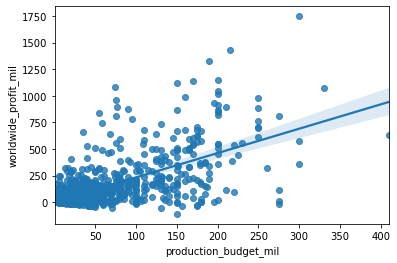

In [26]:
sns.regplot(x='production_budget_mil', y='worldwide_profit_mil', data=competing_studio_budgets_ratings_df);

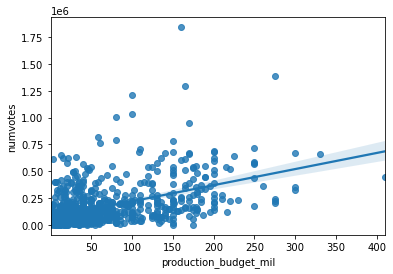

In [27]:
sns.regplot(x='production_budget_mil', y='numvotes', data=competing_studio_budgets_ratings_df);

## How does movie genre affect outcomes?
- ROI is highest for Documentary, Horror, Mystery, and Thriller
- Interest (numratings, popularity) is highest for Western, Sci-Fi, Adventure, Action
- Average worldwide profit is highest for Animation, Sci-Fi, Adventure, Action

In [28]:
set_of_genres = set()
for movie_row in competing_studio_budgets_ratings_df['genres'].dropna():
    set_of_genres.update(movie_row.split(','))

list_of_genres = list(set_of_genres)

Here I am creating a new data frame that will contain rows for every genre. This way we can run `.groupby('genre')` to get summarizing statistics for each genre.

In [29]:
tmp_df_columns = list(competing_studio_budgets_ratings_df.columns)
tmp_df_columns.append('genre')
tmp_df = pd.DataFrame(columns=tmp_df_columns)


for genre in list_of_genres:
    filt = competing_studio_budgets_ratings_df['genres'].str.contains(genre, na=False)
    filt_df = competing_studio_budgets_ratings_df[filt]
    filt_df['genre'] = genre
    tmp_df = pd.concat([tmp_df, filt_df])
    
long_competing_studio_budgets_ratings_df = tmp_df

<ipython-input-29-72870965b343>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['genre'] = genre


In [31]:
#
competing_studio_budgets_ratings_by_genre_df = long_competing_studio_budgets_ratings_df.groupby('genre')[['production_budget_mil', 'worldwide_profit_mil', 'ROI', 'averagerating', 'numvotes']].mean()

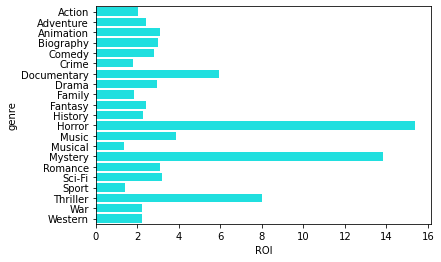

In [32]:
sns.barplot(y=competing_studio_budgets_ratings_by_genre_df.index, 
            x=competing_studio_budgets_ratings_by_genre_df['ROI'],
            color = 'cyan');

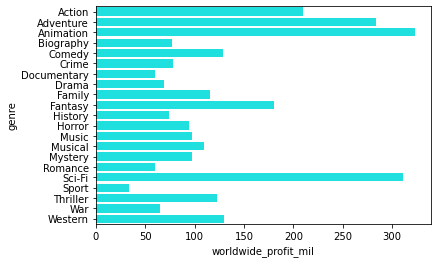

In [33]:
sns.barplot(y=competing_studio_budgets_ratings_by_genre_df.index, 
            x=competing_studio_budgets_ratings_by_genre_df['worldwide_profit_mil'],
            color = 'cyan');

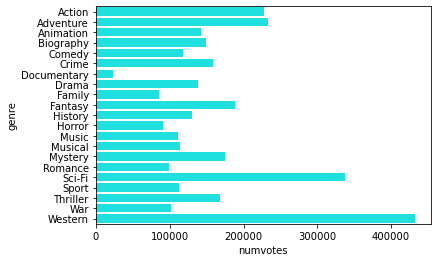

In [34]:
sns.barplot(y=competing_studio_budgets_ratings_by_genre_df.index, 
            x=competing_studio_budgets_ratings_by_genre_df['numvotes'],
            color = 'cyan');

## How do movie directors affect outcomes?


In [35]:
# created top 50 directors measured by worldwide profit
top_50_worldwide_profit_df = competing_studio_budgets_ratings_df.sort_values('worldwide_profit_mil', ascending=False).head(50)
#
top_50_ROI_df = competing_studio_budgets_ratings_df.sort_values('ROI', ascending=False).head(50)

In [36]:
principals_top_50_worldwide_profit_df = imdb_principals_df.merge(top_50_worldwide_profit_df, on='movie_id', how='inner')

In [37]:
filt = (principals_top_50_worldwide_profit_df['category'] == 'director')
sorted_df = principals_top_50_worldwide_profit_df[filt].sort_values('worldwide_profit_mil', ascending=False)
sorted_df.head(10)[['primary_name', 'primary_title_x', 'worldwide_profit_mil']]

,primary_name,primary_title_x,worldwide_profit_mil
436,Joe Russo,Avengers: Infinity War,1748.13
435,Anthony Russo,Avengers: Infinity War,1748.13
35,Colin Trevorrow,Jurassic World,1433.85
455,James Wan,Furious 7,1328.72
85,Ryan Coogler,Black Panther,1148.26
465,J.A. Bayona,Jurassic World: Fallen Kingdom,1135.77
175,Chris Buck,Frozen,1122.47
176,Jennifer Lee,Frozen,1122.47
245,Kyle Balda,Minions,1086.34
375,Joss Whedon,Avengers: Age of Ultron,1072.41


In [38]:
principals_top_50_ROI_df = imdb_principals_df.merge(top_50_ROI_df, on='movie_id', how='inner')
filt = principals_top_50_ROI_df['category'] == 'director'
sorted_df = principals_top_50_ROI_df[filt].sort_values('ROI', ascending=False)
sorted_df.head(10)[['primary_name', 'primary_title_x', 'ROI']]

,primary_name,primary_title_x,ROI
234,Chris Lofing,The Gallows,415.56
233,Travis Cluff,The Gallows,415.56
5,William Brent Bell,The Devil Inside,100.76
203,Tod Williams,Paranormal Activity 2,58.17
413,Jordan Peele,Get Out,50.07
114,Bradley Parker,Chernobyl Diaries,41.41
36,Ariel Schulman,Paranormal Activity 3,40.41
35,Henry Joost,Paranormal Activity 3,40.41
283,John R. Leonetti,Annabelle,38.52
253,Daniel Stamm,The Last Exorcism,37.98


#### Since we're suggesting certain genres, let's pick directors that make good movies in that genre
- Limit directors to our suggested genres
    - Add suggested genres to filt variable to narrow down to 
- horizontal bar graph
    - names of directors and how much profit they made


## Conclusions

## Next Steps